## MC
------------

Monte Carlo simulations are a powerful and versatile tool in portfolio optimization, offering a probabilistic approach to decision-making under uncertainty.
It simulations generate a wide range of possible future price scenarios for assets based on historical data, statistical models, or assumed distributions (e.g., normal distribution of returns), these scenarios incorporate randomness to reflect the uncertainty of real-world market movements.
For each simulated scenario, portfolio metrics such as returns, volatility (standard deviation), and risk-adjusted measures (e.g., Sharpe ratio) are computed. The simulations provide a distribution of potential outcomes, enabling investors to assess the likelihood of achieving specific return or risk thresholds.
> The goal is to identify the "efficient frontier," which represents portfolios offering the highest expected return for a given level of risk

By simulating extreme market conditions, Monte Carlo methods allow for stress testing of portfolio resilience, this helps in understanding the potential impact of rare events (e.g., financial crises) and optimizing portfolios to withstand such shocks.

>By simulating numerous possible outcomes and exploring vast combinations of portfolio allocations, Monte Carlo methods enable investors to optimize portfolios that are resilient, efficient, and tailored to their risk-return profiles.


---------
> SIMULATE FUTURE ASSET PRICES

> ESTIMATE PORTFOLIO METRICS

> EXPLOR THE EFFICIENT FRONTIER

> STRESS TESTING SCENARIO ANALYSIS

> DYNAMIC REBALANCING

---
hidden info
<risk assessment>
<optimizating risk adjusted returns>
<incorporating nonlinear constrains>
<forcasting correlations and diversification>
<evaluating alternative strategies>
<sensitivity analysis>

---
### MODERN PORTFOLIO THEORY

In [2]:
import numpy as np
import pandas as pd
#from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import datetime as dt
from scipy.optimize import minimize
#from stock_forecasting.config import PROCESSED_DATA_DIR
import pickle

In [ ]:
%pip install setuptools==62.0.0 wheel

In [ ]:
%pip install --upgrade pip

In [ ]:
%pip install -e ..

In [ ]:
from stock_forecasting.features import *
from stock_forecasting.plots import *
from stock_forecasting.config import PROCESSED_DATA_DIR, RAW_DATA_DIR, MODELS_DIR
from stock_forecasting.modeling.train import train_lstm, predict

---------------

In [ ]:
%pwd

'c:\\Users\\Daniela\\Desktop\\Fac\\3ºano\\Lab_IACD\\Project2\\stocks-prediction-labia\\notebooks'

In [3]:
from pathlib import Path

#Dan
PROJ_ROOT = Path('c:\\Users\\Daniela\\Desktop\\Fac\\3ºano\\Lab_IACD\\Project2\\stocks-prediction-labia')
# logger.info(f"PROJ_ROOT path is: {PROJ_ROOT}")

DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
INTERIM_DATA_DIR = DATA_DIR / "interim"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
EXTERNAL_DATA_DIR = DATA_DIR / "external"
MODELS_DIR = PROJ_ROOT / "models"

In [ ]:
from pathlib import Path

#Const
PROJ_ROOT = Path('c:\\Users\\Daniela\\Desktop\\Fac\\3ºano\\Lab_IACD\\Project2\\stocks-prediction-labia')
# logger.info(f"PROJ_ROOT path is: {PROJ_ROOT}")

DATA_DIR = PROJ_ROOT / "data"
RAW_DATA_DIR = DATA_DIR / "raw"
INTERIM_DATA_DIR = DATA_DIR / "interim"
PROCESSED_DATA_DIR = DATA_DIR / "processed"
EXTERNAL_DATA_DIR = DATA_DIR / "external"
MODELS_DIR = PROJ_ROOT / "models"

In [ ]:
df = pdr.DataReader('^SPX', data_source='stooq', start='2010-1-1', end='2023-12-31')

## Using Both Historical and Predicted Data
### HISTORICAL DATA
 Use it to estimate parameters like volatility, correlations, and historical patterns of returns
Generate baseline Monte Carlo simulations for comparison
### PREDICTED DATA
Integrate LSTM predictions for January 2024 into the Monte Carlo framework as the expected mean return or as one of the scenarios.
Use these predictions to adjust simulations for expected future trends.
### Hybrid Approach:
Combine the two by using historical data for broader context and volatility modeling, while integrating LSTM predictions as a factor influencing January 2024's specific simulations.

Data n filtrada

In [4]:
with open(PROCESSED_DATA_DIR / "filtered.pkl", "rb") as  f:
    fuu = pickle.load(f)

print(fuu)

Ticker                           HAL                                   \
Price                           Open       High        Low      Close   
Date                                                                    
2010-01-04 00:00:00+00:00  24.386298  24.878470  24.338669  24.807026   
2010-01-05 00:00:00+00:00  24.830845  25.267448  24.600635  25.124559   
2010-01-06 00:00:00+00:00  25.196001  25.870752  25.116618  25.719927   
2010-01-07 00:00:00+00:00  25.648485  25.815188  25.338892  25.783434   
2010-01-08 00:00:00+00:00  26.156536  27.101187  25.791377  27.085310   
...                              ...        ...        ...        ...   
2024-01-24 00:00:00+00:00  35.128161  36.378519  34.931253  36.260376   
2024-01-25 00:00:00+00:00  36.506506  36.673875  35.443208  36.427742   
2024-01-26 00:00:00+00:00  36.299751  37.274441  36.191452  36.949543   
2024-01-29 00:00:00+00:00  36.673877  36.782176  36.201301  36.614803   
2024-01-30 00:00:00+00:00  35.393981  36.437584  34

In [5]:
fuu = fuu.xs("Close", level="Price", axis=1).pct_change()
fuu = fuu[fuu.index < "2024-01-01"]
print(fuu)

Ticker                          HAL         K       IRM       HES       KEY  \
Date                                                                          
2010-01-04 00:00:00+00:00       NaN       NaN       NaN       NaN       NaN   
2010-01-05 00:00:00+00:00  0.012800  0.002271  0.003058  0.006175  0.038721   
2010-01-06 00:00:00+00:00  0.023697  0.000189  0.032230  0.002675 -0.006483   
2010-01-07 00:00:00+00:00  0.002469  0.009819  0.016033  0.019146  0.042414   
2010-01-08 00:00:00+00:00  0.050493 -0.001870  0.002907  0.013705  0.017215   
...                             ...       ...       ...       ...       ...   
2023-12-22 00:00:00+00:00 -0.001365  0.011699  0.004634  0.002805  0.000700   
2023-12-26 00:00:00+00:00  0.012572  0.009545  0.007208  0.014124  0.011197   
2023-12-27 00:00:00+00:00 -0.010526  0.003091  0.005295 -0.000337  0.004844   
2023-12-28 00:00:00+00:00 -0.012275  0.008157  0.005125 -0.025845  0.001377   
2023-12-29 00:00:00+00:00 -0.001657  0.005214 -0.008

In [6]:
# Order columns alphabetically
fuu = fuu.sort_index(axis=1)

# Print the sorted DataFrame
print(fuu)

Ticker                            A      AAPL       ABT      ACGL       ACN  \
Date                                                                          
2010-01-04 00:00:00+00:00       NaN       NaN       NaN       NaN       NaN   
2010-01-05 00:00:00+00:00 -0.010863  0.001729 -0.008079 -0.003336  0.006180   
2010-01-06 00:00:00+00:00 -0.003553 -0.015907  0.005554 -0.004323  0.010631   
2010-01-07 00:00:00+00:00 -0.001297 -0.001848  0.008284 -0.005882 -0.000935   
2010-01-08 00:00:00+00:00 -0.000324  0.006648  0.005113 -0.001972 -0.003977   
...                             ...       ...       ...       ...       ...   
2023-12-22 00:00:00+00:00  0.004534 -0.005548  0.005070 -0.004315  0.016344   
2023-12-26 00:00:00+00:00  0.001720 -0.002841  0.001834 -0.004469 -0.002878   
2023-12-27 00:00:00+00:00  0.000072  0.000518  0.005127  0.000408  0.001103   
2023-12-28 00:00:00+00:00 -0.000358  0.002226  0.005556  0.007071 -0.006303   
2023-12-29 00:00:00+00:00 -0.003612 -0.005424 -0.002

Data filtrada

In [7]:
with open(MODELS_DIR / "predictions.pkl", "rb") as  f:
    foo = pickle.load(f)

print(foo)

                                    A        AAPL         ABT       ACGL  \
Date                                                                       
2024-01-02 00:00:00+00:00  137.876383  184.498739  107.863139  71.822264   
2024-01-03 00:00:00+00:00  137.802864  184.481583  108.200438  71.760927   
2024-01-04 00:00:00+00:00  137.727084  184.586661  108.646210  71.872957   
2024-01-05 00:00:00+00:00  137.305715  184.203784  108.902665  71.778654   
2024-01-08 00:00:00+00:00  137.369698  184.324842  109.316175  71.865984   
2024-01-09 00:00:00+00:00  130.197189  184.434440  111.035987  72.544258   
2024-01-10 00:00:00+00:00  130.265698  184.557079  111.488240  72.622080   
2024-01-11 00:00:00+00:00  130.385192  184.779113  112.002845  72.774941   
2024-01-12 00:00:00+00:00  130.199638  184.381166  112.277772  72.745835   
2024-01-16 00:00:00+00:00  130.267232  184.458294  112.653409  72.790322   
2024-01-17 00:00:00+00:00  127.359354  181.587067  112.428299  74.821923   
2024-01-18 0

In [8]:
# Order columns alphabetically
foo = foo.sort_index(axis=1)

# Print the sorted DataFrame
print(foo)

                                    A        AAPL         ABT       ACGL  \
Date                                                                       
2024-01-02 00:00:00+00:00  137.876383  184.498739  107.863139  71.822264   
2024-01-03 00:00:00+00:00  137.802864  184.481583  108.200438  71.760927   
2024-01-04 00:00:00+00:00  137.727084  184.586661  108.646210  71.872957   
2024-01-05 00:00:00+00:00  137.305715  184.203784  108.902665  71.778654   
2024-01-08 00:00:00+00:00  137.369698  184.324842  109.316175  71.865984   
2024-01-09 00:00:00+00:00  130.197189  184.434440  111.035987  72.544258   
2024-01-10 00:00:00+00:00  130.265698  184.557079  111.488240  72.622080   
2024-01-11 00:00:00+00:00  130.385192  184.779113  112.002845  72.774941   
2024-01-12 00:00:00+00:00  130.199638  184.381166  112.277772  72.745835   
2024-01-16 00:00:00+00:00  130.267232  184.458294  112.653409  72.790322   
2024-01-17 00:00:00+00:00  127.359354  181.587067  112.428299  74.821923   
2024-01-18 0

### Estimate Parameters:
calculate mean return and standard diviation

estimate the correlation matrix for all stocks

In [8]:
def get_data():
    stockData = pd.read_pickle(PROCESSED_DATA_DIR / "filtered.pkl")
    returns = stockData.xs("Close", level="Price", axis=1).pct_change()
    returns = returns[returns.index < "2024-01-01"]
    returns = returns.sort_index(axis=1)
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix


meanReturns, covMatrix = get_data()

print(meanReturns)

#give random weights to portfolio
weights = np.random.random(len(meanReturns))
weights/=np.sum(weights)

#print(weights)



Ticker
A        0.000713
AAPL     0.001122
ABT      0.000590
ACGL     0.000746
ACN      0.000793
           ...   
XEL      0.000516
XOM      0.000383
YUM      0.000659
ZBH      0.000371
^GSPC    0.000469
Length: 392, dtype: float64


#### Instead of using random weigths you can have them based on:

-annual volatility

-minimum variance portfolio

-ERC(Equal Risk Contribution) : Assign weights so that each asset contributes equally to portfolio risk. This is a more advanced form of risk parity.
the idea of the strategy is to find a risk-balanced portfolio such that the risk contribution is the same for all assets of the portfolio
The ERC portfolio may be viewed as a portfolio “between” the 1/n portfolio(in this case annual volatility) and the minimum variance portfolio.


In [ ]:
#ERC


def calculate_erc_weights(cov_matrix):
    n = cov_matrix.shape[0]

    # Objective function to minimize: squared differences in risk contributions
    def objective(w):
        portfolio_vol = np.sqrt(w.T @ cov_matrix @ w)
        marginal_contributions = cov_matrix @ w
        risk_contributions = w * marginal_contributions / portfolio_vol
        # Target: all risk contributions should be equal
        target = portfolio_vol / n
        return np.sum((risk_contributions - target) ** 2)

    # Initial guess: equal weights
    init_weights = np.ones(n) / n

    # Constraints: weights sum to 1
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    # Bounds: no short-selling (weights >= 0)
    bounds = [(0, 1) for _ in range(n)]

    # Solve optimization
    result = minimize(objective, init_weights, bounds=bounds, constraints=constraints)
    return result.x


weights = calculate_erc_weights(covMatrix)

print("ERC Weights:", weights)


ERC Weights: [0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102 0.00255102
 0.00255102 0.00255102 0.00255102 0.00255102 0.00

In [ ]:
def portfolio_volatility(weights, cov_matrix):
    """Calculate portfolio volatility."""
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def risk_contribution(weights, cov_matrix):
    """Calculate risk contribution of each asset."""
    port_vol = portfolio_volatility(weights, cov_matrix)
    marginal_contribution = np.dot(cov_matrix, weights)
    return weights * marginal_contribution / port_vol

def risk_parity_objective(weights, cov_matrix):
    """Objective function for ERC optimization."""
    # Calculate risk contributions
    contributions = risk_contribution(weights, cov_matrix)
    # Target: minimize squared differences from average contribution
    average_contribution = contributions.sum() / len(contributions)
    return np.sum((contributions - average_contribution) ** 2)

def get_erc_weights(cov_matrix):
    """Calculate ERC weights."""
    num_assets = cov_matrix.shape[0]
    initial_weights = np.ones(num_assets) / num_assets  # Start with equal weights
    bounds = [(0, 1) for _ in range(num_assets)]  # No short selling, weights between 0 and 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Weights sum to 1

    # Minimize the ERC objective function
    result = minimize(
        risk_parity_objective,
        initial_weights,
        args=(cov_matrix,),
        bounds=bounds,
        constraints=constraints,
    )
    return result.x  # Optimized weights

----------------
### generate random scenarions

#### GBM(geometric Brownian motion)
- is a continuous-time stochastic process in which the logarithm of the randomly varying quantity follows a Brownian motion (also called a Wiener process) with drift. It is an important example of stochastic processes satisfying a stochastic differential equation (SDE); in particular, it is used in mathematical finance to model stock prices in the Black–Scholes model.


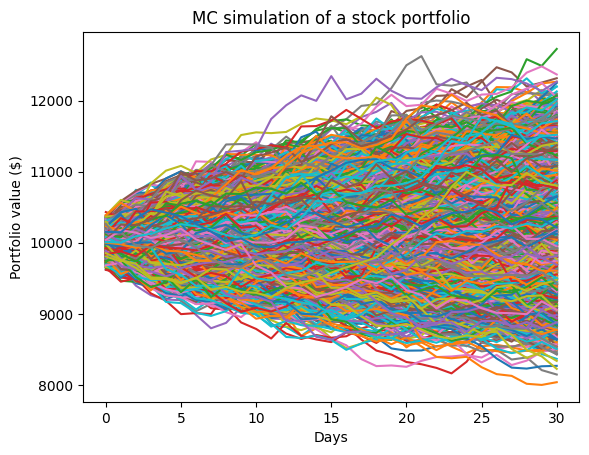

In [ ]:
#MC simulater
#nº of simulations
mc_simes = 5001
T = 30 #days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T #transpose

portfolio_sins = np.full(shape=(T, mc_simes), fill_value=0.0)

initialPortfolio = 10000 #started with initialPortfolio money

for m in range(0, mc_simes):
    #mc loops
    Z = np.random.normal(size=(T, len(weights))) #T com o nº de stocks
    L = np.linalg.cholesky(covMatrix) #lower triangle // nº of stocks by the n of stocks

    dailyReturns = meanM + np.inner(L, Z)
    portfolio_sins[:, m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sins)
plt.ylabel('Portfolio value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

In [11]:
print(type(foo))

predicted_prices = foo.iloc[:, 1:].values
print(predicted_prices)


<class 'pandas.core.frame.DataFrame'>
[[ 184.49873876  107.86313936   71.82226393 ...  126.95156642
   120.94029432 4743.30330906]
 [ 184.48158347  108.20043798   71.76092661 ...  126.51684028
   121.18509849 4743.06638726]
 [ 184.58666086  108.64621004   71.87295725 ...  126.30879187
   121.51427392 4733.82916035]
 ...
 [ 193.79559928  110.51103578   76.44950109 ...  126.84554398
   120.8040657  4867.04247816]
 [ 193.6908653   110.69169005   76.52804115 ...  126.8108409
   121.22790056 4874.92909158]
 [ 193.96156953  111.23617505   76.67994578 ...  126.42586305
   121.46072854 4874.43657811]]


In [15]:

# Load mean, covariance, and predicted prices
mean = meanReturns
covMatrix = covMatrix
predicted_prices = foo.iloc[:, 1:].values

# Monte Carlo Simulation
num_simulations = 5100 #aumentar
num_assets = len(mean)
num_days = 30

# Simulate daily returns
simulated_returns = np.random.multivariate_normal(mean, covMatrix, (num_simulations, num_days))

# Random portfolio weights
weights = np.random.dirichlet(np.ones(num_assets), size=num_simulations)

# Portfolio returns
portfolio_returns = np.sum(simulated_returns @ weights.T, axis=1)

# Evaluate Sharpe Ratios
portfolio_mean_returns = np.mean(portfolio_returns, axis=1)
portfolio_volatility = np.std(portfolio_returns, axis=1)
risk_free_rate = 0.01
sharpe_ratios = (portfolio_mean_returns - risk_free_rate) / portfolio_volatility

# Optimal Portfolio
optimal_index = np.argmax(sharpe_ratios)
optimal_weights = weights[optimal_index]

print("Optimal Portfolio Weights:", optimal_weights)


Optimal Portfolio Weights: [1.27236163e-04 4.36136911e-03 3.04396387e-03 6.12805203e-04
 4.41234873e-04 1.03271624e-03 2.12651000e-03 2.52104163e-03
 1.96296333e-03 4.77462610e-04 2.44934806e-03 2.50748802e-03
 4.41241639e-03 5.12021284e-05 6.47176435e-03 5.72848462e-03
 2.85727252e-03 3.04050400e-03 3.98986679e-03 1.24722960e-02
 9.16819925e-04 5.86933372e-03 2.07380681e-03 1.95641470e-03
 4.00865343e-04 5.91732770e-03 2.29318441e-04 1.09520609e-03
 4.79963533e-03 4.80180281e-03 1.62155204e-03 5.17515980e-04
 2.16841507e-03 1.81202484e-03 2.65023951e-03 3.38120961e-03
 6.81920816e-04 1.66968110e-03 2.56268145e-03 4.89107373e-03
 2.57466817e-04 4.15905309e-04 2.27136046e-04 4.19103338e-03
 1.90663623e-04 5.71357475e-03 2.72850942e-03 1.40407740e-03
 4.45178099e-03 1.70592055e-03 8.41923907e-04 5.39777427e-03
 5.99289611e-03 1.16401114e-02 3.33005833e-04 2.56449156e-03
 2.11545245e-03 3.02769309e-03 2.06906904e-03 6.59113356e-04
 3.78512859e-04 1.16167338e-02 2.12262778e-03 6.95398150e-

ver:
Apply the optimal_weights to your available capital to determine the exact investment in each asset

4. Validating the Model with Predicted Prices
Since you have predicted closing prices for January 2024, you can validate the Monte Carlo results:

Compute the actual returns from predicted prices:

python
Copiar código
predicted_returns = (predicted_prices[1:] - predicted_prices[:-1]) / predicted_prices[:-1]
Apply the optimal weights to the predicted returns to assess how well the Monte Carlo model predicts.


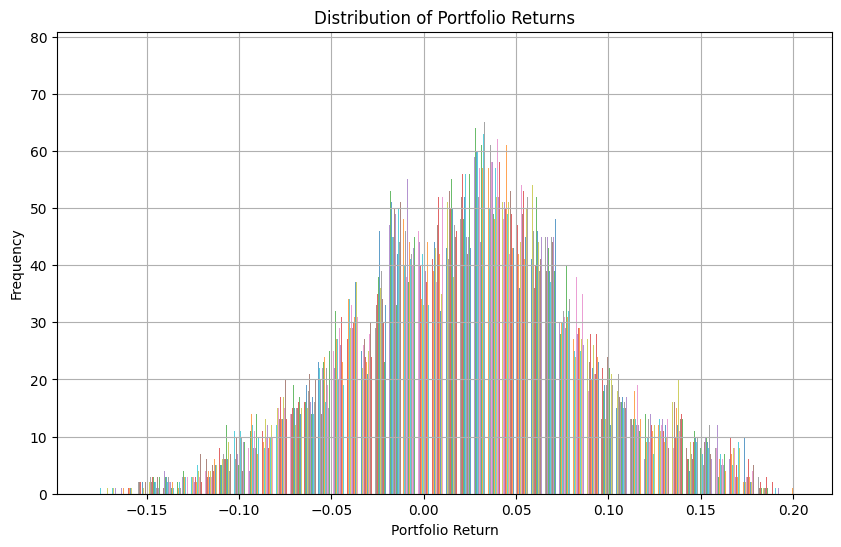

In [13]:
# Assuming `portfolio_returns` contains the simulated portfolio returns
plt.figure(figsize=(10, 6))
plt.hist(portfolio_returns, bins=50, alpha=0.7)
plt.title("Distribution of Portfolio Returns")
plt.xlabel("Portfolio Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


This histogram shows the distribution of portfolio returns across all simulations

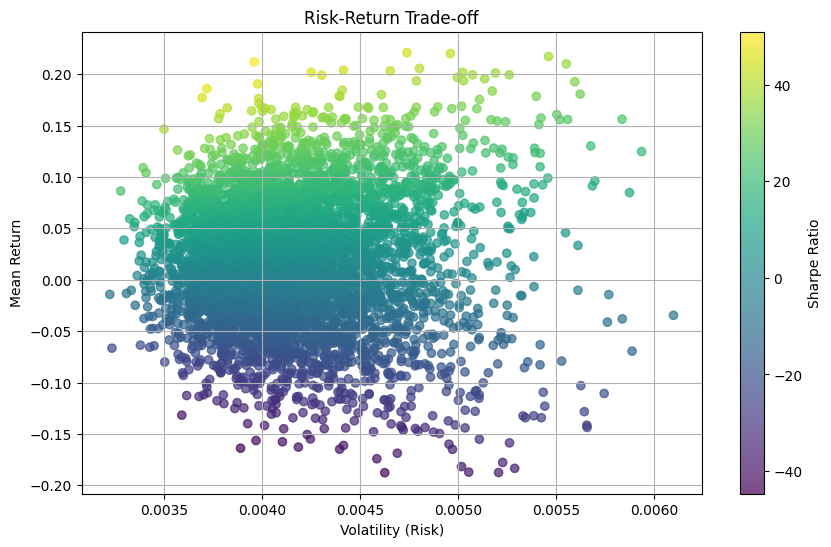

In [20]:
# Assuming `portfolio_mean_returns` and `portfolio_volatility` are calculated
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatility, portfolio_mean_returns, c=sharpe_ratios, cmap='viridis', alpha=0.7)
plt.colorbar(label='Sharpe Ratio')
plt.title("Risk-Return Trade-off")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Mean Return")
plt.grid(True)
plt.show()

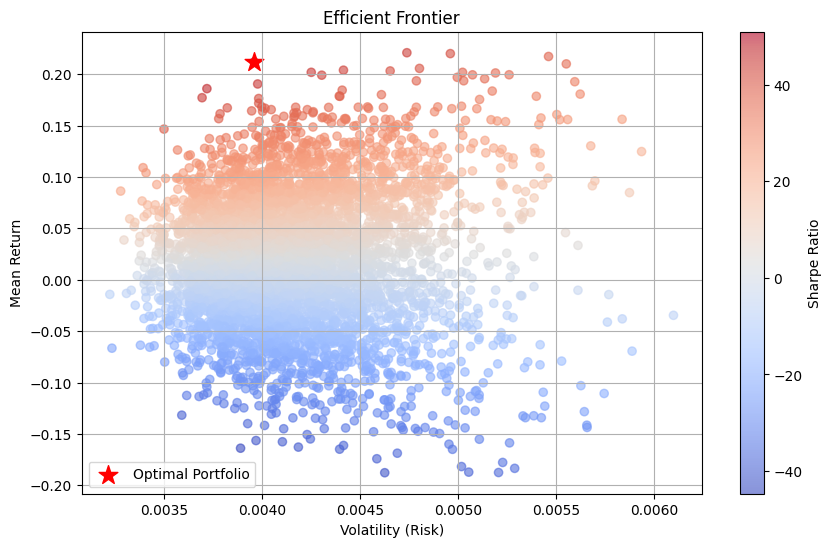

In [21]:
# Efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatility, portfolio_mean_returns, c=sharpe_ratios, cmap='coolwarm', alpha=0.6)
plt.title("Efficient Frontier")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Mean Return")
plt.colorbar(label="Sharpe Ratio")
plt.grid(True)

# Highlight the optimal portfolio
plt.scatter(
    portfolio_volatility[optimal_index], portfolio_mean_returns[optimal_index],
    color='red', marker='*', s=200, label='Optimal Portfolio'
)
plt.legend()
plt.show()

Visualize the risk (volatility) vs. return of each simulated portfolio

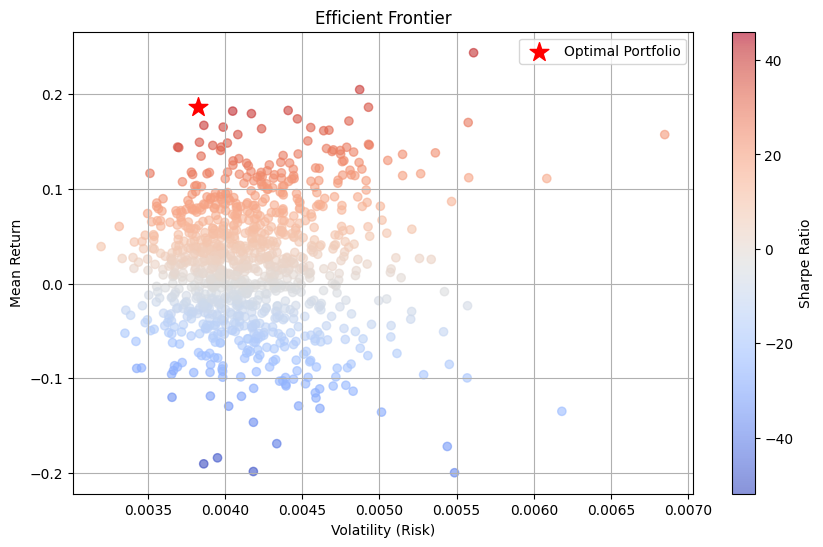

In [ ]:
# Efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatility, portfolio_mean_returns, c=sharpe_ratios, cmap='coolwarm', alpha=0.6)
plt.title("Efficient Frontier")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Mean Return")
plt.colorbar(label="Sharpe Ratio")
plt.grid(True)

# Highlight the optimal portfolio
plt.scatter(
    portfolio_volatility[optimal_index], portfolio_mean_returns[optimal_index],
    color='red', marker='*', s=200, label='Optimal Portfolio'
)
plt.legend()
plt.show()


---
elaborar modelo

In [ ]:
'''
During Simulations: Calculate the Sharpe or Sortino Ratio for each portfolio in the Monte Carlo simulations.
Selection: Use these metrics as the criterion for selecting the optimal portfolio.
'''

# Example data
risk_free_rate = 0.03  # Annualized risk-free rate (3%)
portfolio_returns = np.random.normal(0.1, 0.15, 10000)  # Simulated portfolio returns
portfolio_volatility = np.std(portfolio_returns)

# Sharpe Ratio
sharpe_ratio = (np.mean(portfolio_returns) - risk_free_rate) / portfolio_volatility

# Sortino Ratio
negative_returns = portfolio_returns[portfolio_returns < risk_free_rate]
downside_deviation = np.std(negative_returns)
sortino_ratio = (np.mean(portfolio_returns) - risk_free_rate) / downside_deviation

print("Sharpe Ratio:", sharpe_ratio)
print("Sortino Ratio:", sortino_ratio)

In [28]:

# Load mean, covariance, and predicted prices
mean = meanReturns
covMatrix = covMatrix
predicted_prices = foo.iloc[:, 1:].values

# Monte Carlo Simulation
num_simulations = 3000 #aumentar
num_assets = len(mean)
num_days = 30

# Simulate daily returns
simulated_returns = np.random.multivariate_normal(mean, covMatrix, (num_simulations, num_days))

# Random portfolio weights
weights = np.random.dirichlet(np.ones(num_assets), size=num_simulations)

# Portfolio returns
portfolio_returns = np.sum(simulated_returns @ weights.T, axis=1)

# Evaluate Sharpe Ratios
portfolio_mean_returns = np.mean(portfolio_returns, axis=1)
portfolio_volatility = np.std(portfolio_returns, axis=1)
risk_free_rate = 0.01
sharpe_ratios = (portfolio_mean_returns - risk_free_rate) / portfolio_volatility

# Downside deviation calculation
target_return = risk_free_rate  # Usually, the risk-free rate is the threshold
downside_deviation = np.sqrt(
    np.mean(np.minimum(0, portfolio_returns - target_return) ** 2, axis=1)
)

# Sortino Ratio
sortino_ratios = (portfolio_mean_returns - risk_free_rate) / downside_deviation

# Combined evaluation: Weighted score of Sharpe and Sortino Ratios
combined_scores = 0.5 * sharpe_ratios + 0.5 * sortino_ratios

# Optimal Portfolio
optimal_index = np.argmax(combined_scores)
optimal_weights = weights[optimal_index]

print("Optimal Portfolio Weights:", optimal_weights)


Optimal Portfolio Weights: [2.41764248e-03 3.03829596e-03 1.13692360e-03 6.32253595e-03
 1.44751854e-03 8.12791948e-04 7.47263359e-04 2.78058176e-03
 1.14513790e-03 2.87310454e-03 1.91532167e-03 2.55528626e-03
 6.27371134e-03 2.73222455e-03 1.29169273e-03 1.95528759e-03
 6.08833873e-04 1.77892053e-03 1.36172856e-02 1.33528280e-03
 1.02923011e-03 7.63303579e-05 1.00158300e-03 1.81302582e-03
 4.37990634e-03 4.02193875e-04 8.81976019e-03 3.07594773e-03
 4.01001943e-03 7.71298117e-04 1.02502396e-04 4.11485837e-04
 5.53258079e-03 6.66253082e-04 2.43797978e-03 4.90849666e-03
 4.86832506e-03 1.48506352e-04 2.82161697e-03 4.17606760e-04
 3.53039900e-04 1.85260706e-03 3.59674491e-03 4.66333595e-04
 3.11926680e-03 3.43977996e-03 3.09896915e-04 2.95382734e-03
 7.28498841e-04 2.08880693e-03 7.04135376e-03 7.35046012e-04
 5.80755373e-03 2.96874733e-03 6.68888771e-03 4.76678188e-04
 1.88372996e-03 4.04863892e-03 7.21450612e-03 5.03144546e-03
 1.36715108e-03 1.45472459e-03 5.40796660e-03 1.67279874e-

C:\Users\Daniela\AppData\Local\Temp\ipykernel_4564\3454284034.py:33: RuntimeWarning: divide by zero encountered in divide
  sortino_ratios = (portfolio_mean_returns - risk_free_rate) / downside_deviation


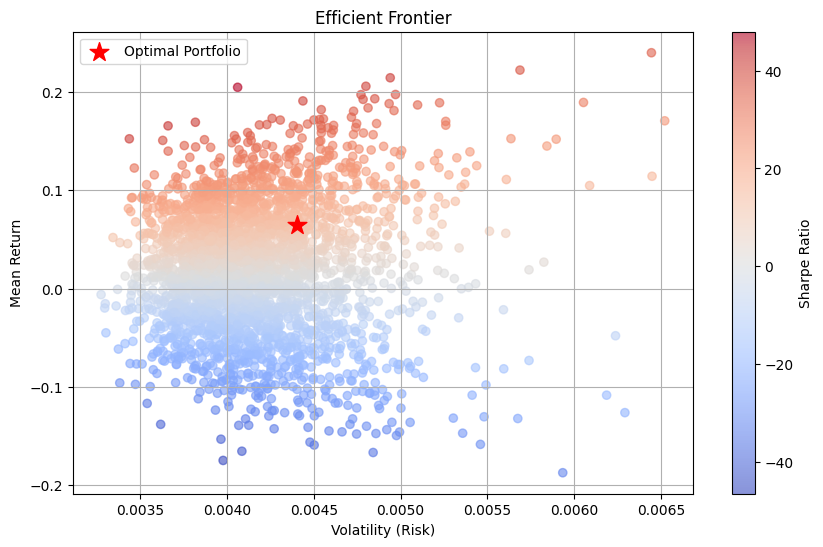

In [29]:
# Efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatility, portfolio_mean_returns, c=sharpe_ratios, cmap='coolwarm', alpha=0.6)
plt.title("Efficient Frontier")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Mean Return")
plt.colorbar(label="Sharpe Ratio")
plt.grid(True)

# Highlight the optimal portfolio
plt.scatter(
    portfolio_volatility[optimal_index], portfolio_mean_returns[optimal_index],
    color='red', marker='*', s=200, label='Optimal Portfolio'
)
plt.legend()
plt.show()


foi escolhido um portfolio com maior risco e menor profit que que o modelo normal onde é usado unicamente o sharp ratio

. Define Portfolio States and Actions

States: Represent the portfolio composition and available capital at a given time (e.g., which stocks are held, how much capital remains).

Actions: Allocate or reallocate funds to different stocks. Actions can include:
Buying a stock,
Selling a stock,
Holding a position

In [9]:
''' 
adaptar o modelo de cima mas agora cada dia tem diff valls de weights 

problema, necessita de mais iterações pk mt(MUITO) mais possibilidades
'''

# Inputs
mean = meanReturns.astype(np.float32)  
covMatrix = covMatrix.astype(np.float32)  
num_simulations = 1000
num_assets = len(mean)
num_days = 30
risk_free_rate = 0.01

# Simulate daily returns
simulated_returns = np.random.multivariate_normal(mean, covMatrix, (num_simulations, num_days, num_assets)).astype(np.float32)
# consumes too much space


# Initialize storage for weights and portfolio returns
daily_weights = np.zeros((num_simulations, num_days, num_assets))
daily_portfolio_returns = np.zeros((num_simulations, num_days))

for sim in range(num_simulations):
    for day in range(num_days):
        daily_returns = np.random.multivariate_normal(mean, covMatrix)

        # Generate random weights for the day
        weights = np.random.dirichlet(np.ones(num_assets))
        daily_weights[sim, day] = weights

        # Calculate daily portfolio return
        daily_return = np.dot(simulated_returns[sim, day], weights)
        daily_portfolio_returns[sim, day] = daily_return

# Evaluate portfolio metrics
portfolio_mean_returns = np.mean(daily_portfolio_returns, axis=1)  # Average return per simulation
portfolio_volatility = np.std(daily_portfolio_returns, axis=1)     # Volatility per simulation
sharpe_ratios = (portfolio_mean_returns - risk_free_rate) / portfolio_volatility

# Optimal Portfolio
optimal_index = np.argmax(sharpe_ratios)
optimal_daily_weights = daily_weights[optimal_index]

print("Optimal Daily Weights (per day):")
print(optimal_daily_weights)


MemoryError: Unable to allocate 34.3 GiB for an array with shape (1000, 30, 392, 392) and data type float64

ocupa mt espaço, má ideia

outra opção, fazer sequencialmente( dividir em 3 parted 10 dias cada)

-usar a tecnica de alterar os pesos por dia continua a ocupar mt espaço

-usar o formato inicial mas com os 3 splits(3x o tamanho do anterior)
    talvez usar 6 splits fosse mehor mas 10 também parece sólido


In [26]:

# Inputs
mean = meanReturns  # Assumes mean returns for all assets
covMatrix = covMatrix  # Covariance matrix
num_simulations = 3000
num_assets = len(mean)
num_days = 30
chunk_size = 10  # Days per chunk
risk_free_rate = 0.01

# Initialize storage for optimal weights and returns
optimal_weights_per_chunk = []
portfolio_returns_per_chunk = []
portfolio_mean_returns_per_chunk = []
portfolio_volatility_per_chunk = []
sharpe_ratios_per_chunck = [] 
optimal_index_per_chunk = []


# Sequential Monte Carlo over chunks
for start_day in range(0, num_days, chunk_size):
    end_day = min(start_day + chunk_size, num_days)
    days_in_chunk = end_day - start_day

    # Simulate daily returns for this chunk
    simulated_returns = np.random.multivariate_normal(mean, covMatrix, (num_simulations, days_in_chunk))

    # Generate random portfolio weights
    weights = np.random.dirichlet(np.ones(num_assets), size=num_simulations)

    # Portfolio returns
    portfolio_returns = np.sum(simulated_returns @ weights.T, axis=1)

    # Evaluate Sharpe Ratios
    portfolio_mean_returns = np.mean(portfolio_returns, axis=1)
    portfolio_mean_returns_per_chunk.append(portfolio_mean_returns)
    portfolio_volatility = np.std(portfolio_returns, axis=1)
    portfolio_volatility_per_chunk.append(portfolio_volatility)
    sharpe_ratios = (portfolio_mean_returns - risk_free_rate) / portfolio_volatility
    sharpe_ratios_per_chunck.append(sharpe_ratios)

    # Optimal Portfolio
    optimal_index = np.argmax(sharpe_ratios)
    optimal_weights = weights[optimal_index]
    optimal_weights_per_chunk.append(optimal_weights)
    optimal_index_per_chunk.append(optimal_index)

    # Store the return of the optimal portfolio for this chunk
    chunk_return = portfolio_returns[optimal_index]
    portfolio_returns_per_chunk.append(chunk_return)

# Aggregate Results
print("Optimal Weights Per Chunk:")
for i, weights in enumerate(optimal_weights_per_chunk):
    print(f"Chunk {i+1}: {weights}")

print("\nPortfolio Returns Per Chunk:", portfolio_returns_per_chunk)
total_return = np.sum(portfolio_returns_per_chunk)
print(f"Total Portfolio Return: {total_return:.2f}")


Optimal Weights Per Chunk:
Chunk 1: [2.20031665e-03 1.88618185e-03 3.43055013e-03 4.04515661e-03
 7.57337498e-04 4.08259137e-03 3.72081348e-03 2.05292785e-03
 3.77342344e-03 5.73662951e-03 4.60533875e-04 5.03272377e-03
 3.71596063e-03 6.71222154e-03 3.87491390e-03 1.53087180e-03
 1.90530694e-03 8.11717354e-03 2.21468250e-03 9.24772464e-05
 1.12525494e-03 1.69028955e-03 4.58429490e-03 9.77756336e-04
 1.59128003e-03 2.40372626e-03 5.49871117e-03 2.68430864e-04
 5.79862816e-03 3.39943875e-03 4.63413744e-03 5.37446641e-04
 8.35039369e-03 2.98939208e-03 2.00095956e-03 3.42718593e-04
 1.03943401e-03 3.71262184e-03 4.91818498e-04 1.64549291e-04
 2.69608735e-03 1.90327969e-03 4.03611899e-04 1.26544055e-03
 6.41137277e-03 9.01826556e-04 5.70909680e-04 9.70326233e-04
 2.14967554e-03 1.96236614e-03 2.02040065e-03 7.35354854e-03
 3.02549177e-03 1.25486841e-03 2.98762297e-03 6.82595277e-03
 3.62757868e-03 1.18809509e-02 4.52109345e-04 3.41844086e-03
 1.47226340e-03 3.00644346e-03 1.34153225e-03 3.4

C:\Users\Daniela\AppData\Local\Temp\ipykernel_10396\2793675376.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Assets")


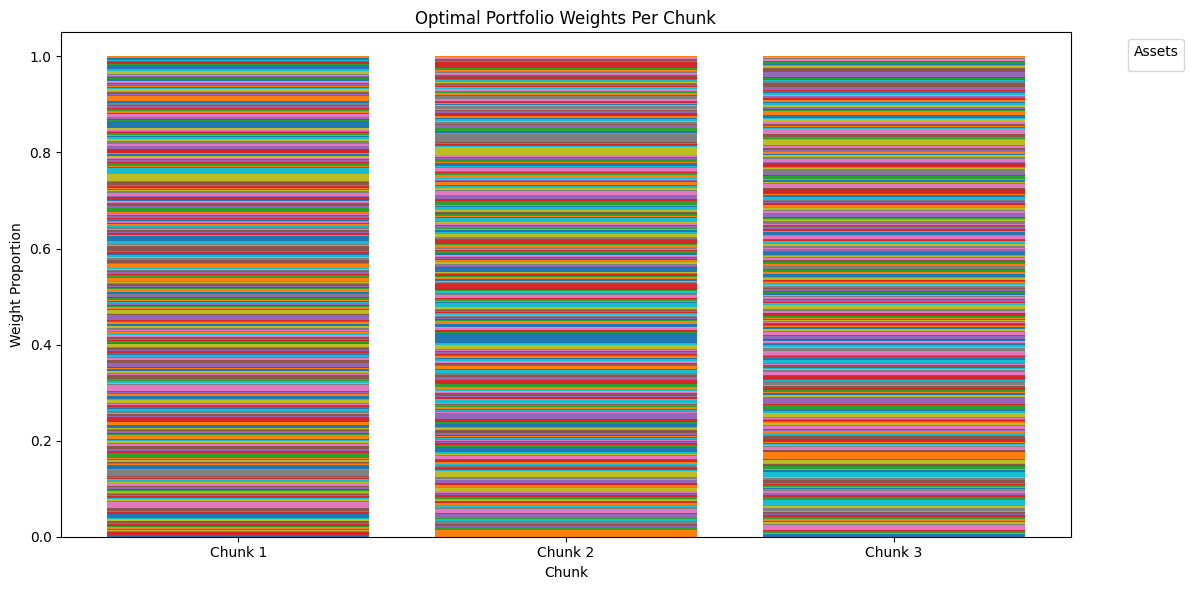

In [14]:
# Example data from simulation
num_chunks = len(optimal_weights_per_chunk)
num_assets = len(optimal_weights_per_chunk[0])
chunks = [f"Chunk {i+1}" for i in range(num_chunks)]

# Convert optimal weights to a NumPy array for easier handling
weights_array = np.array(optimal_weights_per_chunk)

# Plot 1: Optimal Weights Per Chunk
plt.figure(figsize=(12, 6))
for i in range(num_assets):
    plt.bar(chunks, weights_array[:, i], bottom=np.sum(weights_array[:, :i], axis=1))

plt.title("Optimal Portfolio Weights Per Chunk")
plt.xlabel("Chunk")
plt.ylabel("Weight Proportion")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Assets")
plt.tight_layout()
plt.show()



This stacked bar chart shows how the allocation among different assets changes for each chunk. Each bar represents a chunk, and the segments within the bar indicate the proportion allocated to each asset

In [19]:
print(optimal_weights_per_chunk[1][0])
print(len(optimal_weights_per_chunk[1]))

0.003331856656402423
392


C:\Users\Daniela\AppData\Local\Temp\ipykernel_4564\2006254661.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


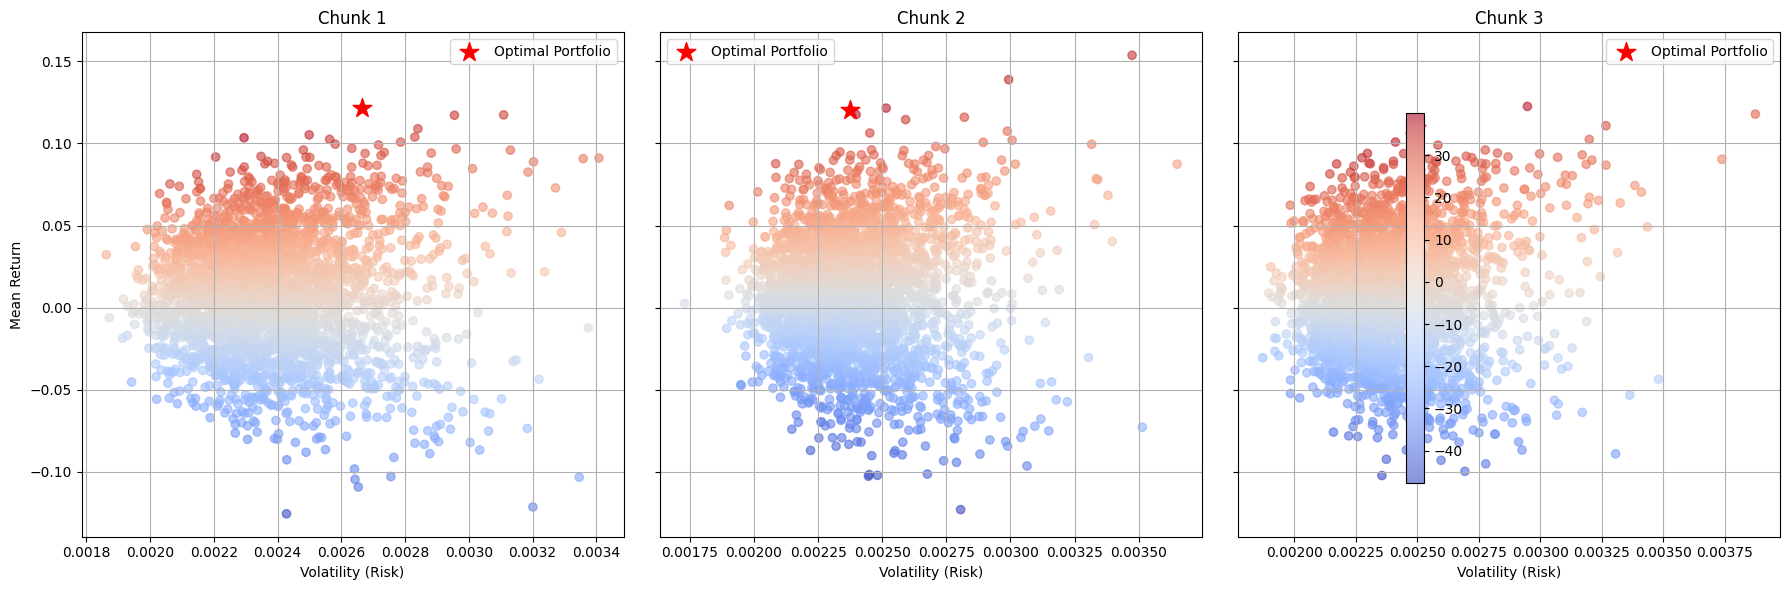

In [27]:
# Assuming portfolio_returns_per_chunk is a list of 3 dictionaries or tuples containing:
# `portfolio_volatility`, `portfolio_mean_returns`, `sharpe_ratios`, and `optimal_index` for each chunk.
risk_free_rate = 0.01
# Number of chunks
num_chunks = len(optimal_weights_per_chunk)

# Create subplots
fig, axes = plt.subplots(1, num_chunks, figsize=(18, 6), sharey=True)  # 1 row, 3 columns

# Loop through each chunk and plot the efficient frontier
for i, chunk_data in enumerate(optimal_weights_per_chunk):
    # Extract data for the current chunk
    portfolio_volatility = portfolio_volatility_per_chunk[i]
    portfolio_mean_returns = portfolio_mean_returns_per_chunk[i]
    sharpe_ratios = (portfolio_mean_returns - risk_free_rate) / portfolio_volatility #chunk_data['sharpe_ratios']
    optimal_index = optimal_index_per_chunk[i]
    
    # Plot in the respective subplot
    ax = axes[i]
    scatter = ax.scatter(
        portfolio_volatility, portfolio_mean_returns, 
        c=sharpe_ratios, cmap='coolwarm', alpha=0.6
    )
    ax.scatter(
        portfolio_volatility[optimal_index], portfolio_mean_returns[optimal_index],
        color='red', marker='*', s=200, label='Optimal Portfolio'
    )
    ax.set_title(f"Chunk {i + 1}")
    ax.set_xlabel("Volatility (Risk)")
    ax.grid(True)
    if i == 0:
        ax.set_ylabel("Mean Return")
    ax.legend()

# Add a colorbar
fig.colorbar(scatter, ax=axes, orientation='vertical', shrink=0.8)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


---

In [ ]:
#np.random.seed(42)
risk_free_rate = 0.03
portfolio_returns = pd.Series(np.random.normal(0.001, 0.01, 1000))
portfolio_volatility = np.std(portfolio_returns)

def calculate_drawdown(returns):
    cumulative_returns = (1 + returns).cumprod()
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    return drawdown.min()

sharpe_ratio = (np.mean(portfolio_returns) - risk_free_rate / 252) / portfolio_volatility
cumulative_return = (1 + portfolio_returns).cumprod().iloc[-1] - 1
drawdown = calculate_drawdown(portfolio_returns)

print(f"Sharpe Ratio: {sharpe_ratio:.3f}")
print(f"Cumulative Return: {cumulative_return:.3%}")
print(f"Maximum Drawdown: {drawdown:.3%}")

**CAPM - Capital Asset Pricing Model**

Beta mede a volatilidade / risco do portfólio em relação ao movimento do mercado.


Beta = 1: O portfólio tem o mesmo risco e a mesma volatilidade do mercado. <br>
Beta > 1: O portfólio é mais volátil do que o mercado.<br>
Beta < 1: O portfólio é menos volátil do que o mercado.<br>
Quanto maior o Beta, maior a correlação entre o portfólio e o mercado.

---

Alpha indica o retorno adicional de um portfólio em relação ao que seria esperado.

Alpha positivo: o portfólio teve um desempenho superior ao esperado.<br>
Alpha negativo: o portfólio teve um desempenho inferior ao esperado.<br>
Alpha zero: O portfólio teve exatamente o retorno esperado.

---

O R-squared indica o grau de correlação entre o portfólio e o mercado.

R-squared = 1 (ou 100%): todos os movimentos do portfólio são explicados pelas flutuações no mercado. O portfólio segue exatamente o comportamento do mercado.<br>
R-squared = 0: o portfólio tem um comportamento independente do mercado.

Quanto mais próximo de 1, mais forte é a relação entre o portfólio e o mercado.

In [ ]:
import yfinance as yf
sp500_data = yf.download('^GSPC', start='2020-01-01', end='2023-12-31')
market_returns = sp500_data['Adj Close'].pct_change().dropna()  #retornos diários

[*********************100%***********************]  1 of 1 completed


In [ ]:
from sklearn.linear_model import LinearRegression

def calculate_capm_metrics(portfolio_returns, market_returns):
    X = market_returns.values.reshape(-1, 1)
    y = portfolio_returns.values
    model = LinearRegression()
    model.fit(X, y)

    beta = model.coef_[0]
    alpha = model.intercept_
    r_squared = model.score(X, y)

    return {"Beta": beta, "Alpha": alpha, "R-squared": r_squared}

portfolio_daily_returns = pd.DataFrame(portfolio_sins).pct_change().dropna().mean(axis=1)
market_daily_returns = market_returns.pct_change().dropna()

capm_metrics = calculate_capm_metrics(portfolio_daily_returns, market_daily_returns)

print(f"Beta: {capm_metrics['Beta']:.3f}")
print(f"Alpha: {capm_metrics['Alpha']:.3%}")
print(f"R-squared: {capm_metrics['R-squared']:.3%}")

ERi: expected return of investment <br> Rf: risk-free rate <br>
Bi: beta <br> ERm: expected return of market <br>

```
ERi = Rf + Bi * (ERm - Rf)

```


In [ ]:
risk_free_rate = 0.03
expected_market_return = 0.08

def calculate_expected_return(risk_free_rate, beta, expected_market_return):
    market_risk_premium = expected_market_return - risk_free_rate
    expected_return = risk_free_rate + beta * market_risk_premium
    return expected_return

expected_return = calculate_expected_return(risk_free_rate, beta, expected_market_return)
print(f"Expected Portfolio Return (CAPM): {expected_return:.3%}")

----------
## References

> https://medium.com/analytics-vidhya/monte-carlo-simulations-for-predicting-stock-prices-python-a64f53585662

> https://journals.ue.wroc.pl/fins/article/download/138/7/458

> https://youtu.be/f9MAFvP5-pA

> http://thierry-roncalli.com/download/erc-slides.pdf

> https://en.wikipedia.org/wiki/Geometric_Brownian_motion

> https://youtu.be/YZL2xdhh7qE

> https://youtu.be/-fCYZjNA7Ps

> https://medium.com/@rahul-mohan-data-portfolio/monte-carlo-simulations-on-stock-portfolios-in-python-64da7012ee9a
